In [5]:
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# Mes modifs
from sklearn.metrics import auc
from sklearn import tree
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import StratifiedKFold
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV,ShuffleSplit
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier

In [2]:
# Load dataset
df = pd.read_csv(".\\nba_logreg.csv")

# extract names, labels, features names and values
names = df['Name'].values.tolist() # players names
labels = df['TARGET_5Yrs'].values # labels
paramset = df.drop(['TARGET_5Yrs','Name'],axis=1).columns.values
df_vals = df.drop(['TARGET_5Yrs','Name'],axis=1).values


# replacing Nan values (only present when no 3 points attempts have been performed by a player)
for x in np.argwhere(np.isnan(df_vals)):
    df_vals[x]=0.0

# normalize dataset
X = MinMaxScaler().fit_transform(df_vals)

In [3]:
def score_classifier(dataset,classifier,labels):
    """
    performs 3 random trainings/tests to build a confusion matrix and prints results with precision and recall scores
    :param dataset: the dataset to work on
    :param classifier: the classifier to use
    :param labels: the labels used for training and validation
    :return:
    """
    kf = KFold(n_splits=3,random_state=50,shuffle=True)
    confusion_mat = np.zeros((2,2))
    recall = 0
    for training_ids,test_ids in kf.split(dataset):
        training_set = dataset[training_ids]
        training_labels = labels[training_ids]
        test_set = dataset[test_ids]
        test_labels = labels[test_ids]
        classifier.fit(training_set,training_labels)
        predicted_labels = classifier.predict(test_set)
        confusion_mat+=confusion_matrix(test_labels,predicted_labels)
        recall += recall_score(test_labels, predicted_labels)

    recall/=3
    print(confusion_mat)
    print("recall mean = ",recall," paramètres: ",classifier.get_params())

In [45]:
%%time
#example of scoring with support vector classifier
score_classifier(X,SVC(),labels)

[[271. 238.]
 [145. 686.]]
recall mean =  0.82551959002102  paramètres:  {'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}
Wall time: 195 ms


In [ ]:
df.TARGET_5Yrs.value_counts()

1.0    831
0.0    509
Name: TARGET_5Yrs, dtype: int64

# REPONSE

# Feature Importance

Ici j'essaie de réduire le nombre de feauture utilisées par rapport à la question 2

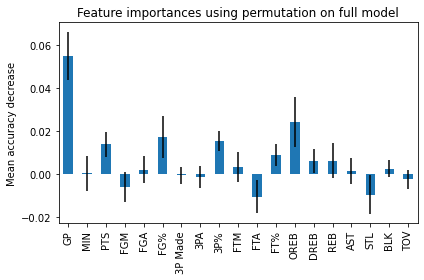

Wall time: 2.34 s


In [46]:
%%time
X_train, X_test, y_train, y_test = train_test_split(X, labels, stratify=labels, random_state=42)

forest = RandomForestClassifier(random_state=0)
forest.fit(X_train, y_train)

result = permutation_importance(
    forest, X_test, y_test, n_repeats=10, random_state=42, n_jobs=1
)
forest_importances = pd.Series(result.importances_mean, index=paramset)


fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

On remarque que les corrélations sont assez faibles mais il semble que GP, PTS, FG%, 3P% et OREB sont les features les plus corrélées avec TARGET_5Yrs

In [47]:
# Features que l'on étudie
df_vals = df[['GP','PTS','FG%','3P%','OREB']].values

for x in np.argwhere(np.isnan(df_vals)):
    df_vals[x]=0.0
X = MinMaxScaler().fit_transform(df_vals)
score_classifier(X,SVC(),labels)

[[263. 246.]
 [150. 681.]]
recall mean =  0.8194340272914348  paramètres:  {'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}


On voit alors que l'impact sur le recall est de 0.003 environ ce qui est une perte acceptable étant donné la question de l'exercice 2.

Maintenant on peut effectuer des tests avec d'autres Classifier et d'autres hyperparamètres.

Je vais notamment utilisé GridSearcgCv pour effectuer mes tests.

In [4]:
# Cette fonction va permettre de départager les modèles grâce à l'ai sous leur courbe AUC
def roc_curves(classifier):
    cv = StratifiedKFold(n_splits=6)

    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    fig, ax = plt.subplots()
    for i, (train, test) in enumerate(cv.split(X, labels)):
        classifier.fit(X[train], labels[train])
        viz = RocCurveDisplay.from_estimator(
            classifier,
            X[test],
            labels[test],
            name="ROC fold {}".format(i),
            alpha=0.3,
            lw=1,
            ax=ax,
        )
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

    ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(
        mean_fpr,
        mean_tpr,
        color="b",
        label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        label=r"$\pm$ 1 std. dev.",
    )

    ax.set(
        xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
        title="Receiver operating characteristic example",
    )
    ax.legend(loc="lower right")
    plt.show()

# SVC

In [6]:
%%time

# Features que l'on étudie
df_vals = df[['GP','PTS','FG%','3P%','OREB']].values
for x in np.argwhere(np.isnan(df_vals)):
    df_vals[x]=0.0
X = MinMaxScaler().fit_transform(df_vals)
shuffle_split = ShuffleSplit(n_splits=3,test_size=.5)

# paramètres à tester
kernel = ['linear','poly', 'rbf']
C = [0.01, 0.1, 1, 10]

# instanciation de GridSearch
parameters = dict(kernel=kernel,C=C)
clf = GridSearchCV(estimator= SVC(), param_grid=parameters,refit = True,verbose=3,cv=shuffle_split, n_jobs=-1, scoring='recall') # 3 fold, with all processors, score recall
clf.fit(X, labels)

# best recall mean
print("Best recall mean= ",clf.best_score_," parameters = ",clf.best_params_,"\n")

#other results
means = clf.cv_results_['mean_test_score']
params = clf.cv_results_['params']
stds = clf.cv_results_['std_test_score']
for mean,std,parameter in zip(means,stds,params):
    print("recall mean= ",round(mean,2),"recall std= ",round(std,2) ," parameters= ",parameter)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best recall mean=  1.0  parameters =  {'C': 0.01, 'kernel': 'linear'} 

recall mean=  1.0 recall std=  0.0  parameters=  {'C': 0.01, 'kernel': 'linear'}
recall mean=  0.73 recall std=  0.02  parameters=  {'C': 0.01, 'kernel': 'poly'}
recall mean=  1.0 recall std=  0.0  parameters=  {'C': 0.01, 'kernel': 'rbf'}
recall mean=  0.97 recall std=  0.01  parameters=  {'C': 0.1, 'kernel': 'linear'}
recall mean=  0.73 recall std=  0.02  parameters=  {'C': 0.1, 'kernel': 'poly'}
recall mean=  0.82 recall std=  0.02  parameters=  {'C': 0.1, 'kernel': 'rbf'}
recall mean=  0.79 recall std=  0.01  parameters=  {'C': 1, 'kernel': 'linear'}
recall mean=  0.75 recall std=  0.01  parameters=  {'C': 1, 'kernel': 'poly'}
recall mean=  0.82 recall std=  0.01  parameters=  {'C': 1, 'kernel': 'rbf'}
recall mean=  0.77 recall std=  0.02  parameters=  {'C': 10, 'kernel': 'linear'}
recall mean=  0.75 recall std=  0.03  parameters=  {'C': 10, 'kernel':

On obtient un recall de 1, soit 100% de precision, mais en regardant la matrice de confusion si après avec le meilleur jeu de paramètres identifiés par gridSearchCv, on voit qu'il y a un problème avec aucun TruePositive identifié. Le model avec ce jeu de paramètre est donc pas adapté.

In [136]:
score_classifier(X,SVC(C=0.01,kernel='linear'),labels)

[[  0. 509.]
 [  0. 831.]]
recall mean =  1.0  paramètres:  {'C': 0.01, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'linear', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}


Néanmoins le deuxième meilleur jeu d'hyperparamètre donne un meilleur score que ceux de base comme on peut voir ci-dessous. Cependant on voit que le model a identifié plus 

In [71]:
score_classifier(X,SVC(C=0.1,kernel='linear'),labels)

[[162. 347.]
 [ 69. 762.]]
recall mean =  0.9166658194885605  paramètres:  {'C': 0.1, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'linear', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}


On constate ainsi que plus C diminue plus le modèle a du mal a distinguer les TruePositives, ce qui certes augmente le recall mais diminue no chance d'identifier les prochains joueurs NBA dont la carrière pro sera supérieur à 5 ans et inversement.

In [75]:
score_classifier(X,SVC(C=0.05,kernel='linear'),labels)

[[ 17. 492.]
 [ 11. 820.]]
recall mean =  0.9866942206639165  paramètres:  {'C': 0.05, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'linear', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}


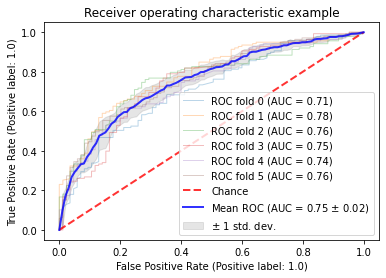

In [122]:
roc_curves(SVC(kernel="linear", probability=True, random_state=np.random.RandomState(0)))

# RandomForestClassifier

In [11]:
%%time

# Features que l'on étudie
df_vals = df[['GP','PTS','FG%','3P%','OREB']].values
for x in np.argwhere(np.isnan(df_vals)):
    df_vals[x]=0.0
X = MinMaxScaler().fit_transform(df_vals)
shuffle_split = ShuffleSplit(n_splits=3,test_size=.5)

# paramètres à tester
n_estimators = [10, 100, 1000]
max_features = ['sqrt', 'log2']

# instanciation de GridSearch
parameters = dict(n_estimators=n_estimators,max_features=max_features)
clf = GridSearchCV(estimator= RandomForestClassifier(), param_grid=parameters,refit = True,verbose=3,cv=shuffle_split, n_jobs=-1, scoring='recall') # 3 fold, with all processors, score recall
clf.fit(X, labels)

# best recall mean
print("Best recall mean= ",clf.best_score_," parameters = ",clf.best_params_,"\n")

#other results
means = clf.cv_results_['mean_test_score']
params = clf.cv_results_['params']
stds = clf.cv_results_['std_test_score']
for mean,std,parameter in zip(means,stds,params):
    print("recall mean= ",round(mean,2),"recall std= ",round(std,2) ," parameters= ",parameter)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best recall mean=  0.7810432945107868  parameters =  {'max_features': 'sqrt', 'n_estimators': 1000} 

recall mean=  0.71 recall std=  0.01  parameters=  {'max_features': 'sqrt', 'n_estimators': 10}
recall mean=  0.77 recall std=  0.02  parameters=  {'max_features': 'sqrt', 'n_estimators': 100}
recall mean=  0.78 recall std=  0.01  parameters=  {'max_features': 'sqrt', 'n_estimators': 1000}
recall mean=  0.69 recall std=  0.01  parameters=  {'max_features': 'log2', 'n_estimators': 10}
recall mean=  0.77 recall std=  0.01  parameters=  {'max_features': 'log2', 'n_estimators': 100}
recall mean=  0.78 recall std=  0.01  parameters=  {'max_features': 'log2', 'n_estimators': 1000}
CPU times: total: 1.98 s
Wall time: 4.33 s


Ici on voit que randomForest n'est pas plus performant. Néanmoins il est plus consistant dans ses résultats.

In [12]:
score_classifier(X,RandomForestClassifier(max_features='sqrt', n_estimators= 1000),labels)

[[262. 247.]
 [184. 647.]]
recall mean =  0.7781631810621681  paramètres:  {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 1000, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


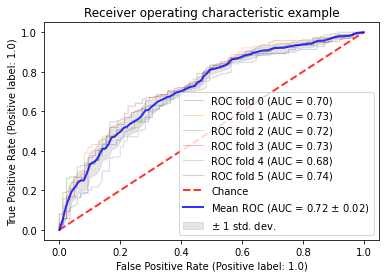

In [13]:
roc_curves(RandomForestClassifier(max_features= 'sqrt', n_estimators= 1000, random_state=2))

# GradientBoostingClassifier

In [8]:
%%time

# Features que l'on étudie
df_vals = df[['GP','PTS','FG%','3P%','OREB']].values
for x in np.argwhere(np.isnan(df_vals)):
    df_vals[x]=0.0
X = MinMaxScaler().fit_transform(df_vals)
shuffle_split = ShuffleSplit(n_splits=3,test_size=.5)

# paramètres à tester
n_estimators = [10, 100, 1000]
learning_rate = [0.001, 0.01, 0.1]
subsample = [0.5, 0.7, 1.0]
max_depth = [3, 7, 9]

# instanciation de GridSearch
parameters = dict(learning_rate=learning_rate, n_estimators=n_estimators, subsample=subsample, max_depth=max_depth)
clf = GridSearchCV(estimator= GradientBoostingClassifier(), param_grid=parameters,refit = True,verbose=3,cv=shuffle_split, n_jobs=-1, scoring='recall') # 3 fold, with all processors, score recall
clf.fit(X, labels)

# best recall mean
print("Best recall mean= ",clf.best_score_," parameters = ",clf.best_params_,"\n")

#other results
means = clf.cv_results_['mean_test_score']
params = clf.cv_results_['params']
stds = clf.cv_results_['std_test_score']
for mean,std,parameter in zip(means,stds,params):
    print("recall mean= ",round(mean,2),"recall std= ",round(std,2) ," parameters= ",parameter)

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best recall mean=  1.0  parameters =  {'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 10, 'subsample': 0.5} 

recall mean=  1.0 recall std=  0.0  parameters=  {'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 10, 'subsample': 0.5}
recall mean=  1.0 recall std=  0.0  parameters=  {'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 10, 'subsample': 0.7}
recall mean=  1.0 recall std=  0.0  parameters=  {'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 10, 'subsample': 1.0}
recall mean=  1.0 recall std=  0.0  parameters=  {'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.5}
recall mean=  1.0 recall std=  0.0  parameters=  {'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.7}
recall mean=  1.0 recall std=  0.0  parameters=  {'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}
recall mean=  0.86 recall std=  0.02  parameters

Même constatation que pour SVC. Le model avec le jeu meilleur jeu de d'hyperparamètres semble être trop simple.

In [52]:
score_classifier(X,GradientBoostingClassifier(learning_rate= 0.001, max_depth= 3, n_estimators= 10, subsample= 0.5),labels)

[[  0. 509.]
 [  0. 831.]]
recall mean =  1.0  paramètres:  {'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.001, 'loss': 'deviance', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 10, 'n_iter_no_change': None, 'random_state': None, 'subsample': 0.5, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}


Néanmoins le deuxième meilleur jeu d'hyperparamètre donne un meilleur score que ceux de base comme on peut voir ci-dessous.

In [81]:
score_classifier(X,GradientBoostingClassifier(learning_rate= 0.001, max_depth= 3, n_estimators= 1000, subsample= 0.7),labels)

[[201. 308.]
 [120. 711.]]
recall mean =  0.8555650753273119  paramètres:  {'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.001, 'loss': 'deviance', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 1000, 'n_iter_no_change': None, 'random_state': None, 'subsample': 0.7, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}


et augmenter le nombre d'estimateur n'a pas amélioré le résultat comme on voit ci dessous

In [82]:
score_classifier(X,GradientBoostingClassifier(learning_rate= 0.001, max_depth= 3, n_estimators= 1500, subsample= 0.7),labels)

[[245. 264.]
 [146. 685.]]
recall mean =  0.8240981506666727  paramètres:  {'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.001, 'loss': 'deviance', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 1500, 'n_iter_no_change': None, 'random_state': None, 'subsample': 0.7, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}


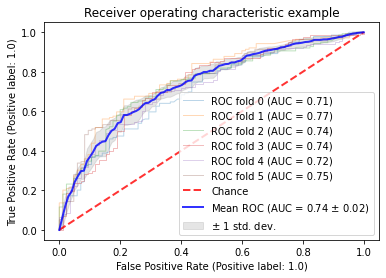

In [121]:
roc_curves(GradientBoostingClassifier(learning_rate= 0.001, max_depth= 3, n_estimators= 1000, subsample= 0.7, random_state=np.random.RandomState(0)))

# Decision Tree

In [7]:
%%time

# Features que l'on étudie
df_vals = df[['GP','PTS','FG%','3P%','OREB']].values
for x in np.argwhere(np.isnan(df_vals)):
    df_vals[x]=0.0
X = MinMaxScaler().fit_transform(df_vals)
# X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.5, random_state=5)
shuffle_split = ShuffleSplit(n_splits=3,test_size=.5)

# paramètres à tester
criterion=['gini','entropy']
max_depth= np.arange(2, 15)
random_state = np.arange(2, 10)

# instanciation de GridSearch
parameters = dict(criterion=criterion, max_depth= max_depth, random_state=random_state)
clf = GridSearchCV(estimator= tree.DecisionTreeClassifier(), param_grid=parameters,refit = True,verbose=3,cv=shuffle_split, n_jobs=-1, scoring='recall') # 3 fold, with all processors, score recall
clf.fit(X, labels)

# best recall mean
print("Best recall mean= ",clf.best_score_," parameters = ",clf.best_params_,"\n")

#other results
means = clf.cv_results_['mean_test_score']
params = clf.cv_results_['params']
stds = clf.cv_results_['std_test_score']
for mean,std,parameter in zip(means,stds,params):
    print("recall mean= ",round(mean,2),"recall std= ",round(std,2) ," parameters= ",parameter)

Fitting 3 folds for each of 208 candidates, totalling 624 fits
Best recall mean=  0.8098242962502321  parameters =  {'criterion': 'entropy', 'max_depth': 2, 'random_state': 2} 

recall mean=  0.74 recall std=  0.14  parameters=  {'criterion': 'gini', 'max_depth': 2, 'random_state': 2}
recall mean=  0.74 recall std=  0.14  parameters=  {'criterion': 'gini', 'max_depth': 2, 'random_state': 3}
recall mean=  0.74 recall std=  0.14  parameters=  {'criterion': 'gini', 'max_depth': 2, 'random_state': 4}
recall mean=  0.74 recall std=  0.14  parameters=  {'criterion': 'gini', 'max_depth': 2, 'random_state': 5}
recall mean=  0.74 recall std=  0.14  parameters=  {'criterion': 'gini', 'max_depth': 2, 'random_state': 6}
recall mean=  0.74 recall std=  0.14  parameters=  {'criterion': 'gini', 'max_depth': 2, 'random_state': 7}
recall mean=  0.74 recall std=  0.14  parameters=  {'criterion': 'gini', 'max_depth': 2, 'random_state': 8}
recall mean=  0.74 recall std=  0.14  parameters=  {'criterion': '

In [9]:
score_classifier(X,tree.DecisionTreeClassifier(max_depth= 2, criterion='entropy',random_state=2),labels)

[[273. 236.]
 [226. 605.]]
recall mean =  0.728446565276391  paramètres:  {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 2, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 2, 'splitter': 'best'}


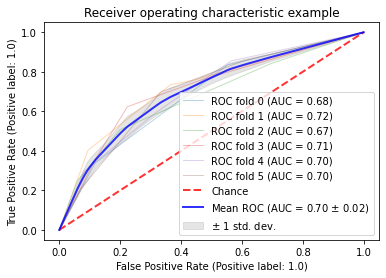

In [10]:
roc_curves(tree.DecisionTreeClassifier(max_depth= 2, criterion='entropy',random_state=2))

# CONCLUSION question 1

Tout d'abord on a effectué un test d'importance en utilisant un Random forest Classifier qui a réduit notre jeu de données à __5 features__. (Tout de même une très légère baisse de recall de 0.003 a été constaté mais est une perte acceptable compte tenu de la question 2).

__GridSearch__ a permis d'effectuer automatiquement et rapidement 3 plis (fold) avec des hyperparamètres différents, les avantages sont:

    - permet de tester efficacement plusieurs hyperparamètres (attention à la taille du jeu de données).
    - la méthode de score est juste un paramètre à préciser et le code est beaucoup plus court

Par défaut pour le SVC, le paramètre C vaut 1, ce qui peut être trop simple pour le model, d'où les 82% en recall dans le test de l'énoncé.
On a aussi vu que 0.01 étant trop compliqué pour le model et qu'il n'arrivait plus a distinguer les TruePositives.
A défaut de devoir jouer sur ce paramètre, le Gradientboosting a identifié des résultats presque aussi similaires à l'SVC. RandomForest donne un bon score mais j'ai  gardé le DecisionTree car celui-ci a un meilleur score et est plus constant dans ses prédictions et cela se voit dans ses courbes ROC qui sont plus linéaires.